# Milestone Project 2 SkimLit

- The purpose is to build an NLP model to read medical asbstracts. 
- Paper being replicated is: https://arxiv.org/abs/1710.06071
- Model being replicated that the above paper used: https://arxiv.org/abs/1612.05251

## Get Data

Data is available at: https://github.com/Franck-Dernoncourt/pubmed-rct

In [44]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [45]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [46]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign
# dev.txt is the validation set

dev.txt   test.txt  train.txt


In [47]:
# Start the experiments with 20k RCT numbers replaced with `@` sign
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [48]:
# Check all the file names in data
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess Data

In [49]:
# Create a function to read files of a document

def get_lines(filename):
    """
    Reads filename and returns the lines of text as a list
    """
    with open(filename, "r") as f:
        return f.readlines()

In [50]:
# Training lines
train_lines = get_lines(data_dir + "train.txt")
train_lines[:5]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n']

In [51]:
# Need to separate labels from text -> Dict

def preprocess_text_with_line_numbers(filename):
    """
    Return a list of dicts of abstract line data
    """
    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []

    # loop through each line in target file
    for line in input_lines:

        if line.startswith("###"):
            
            abstract_id = line
            abstract_lines = ""
        
        elif line.isspace():

            abstract_lines_split = abstract_lines.splitlines()

            for abstract_line_number, abstract_line in enumerate(abstract_lines_split):

                line_data = {}

                target_text_split = abstract_line.split("\t")

                line_data["target"] = target_text_split[0]

                line_data["text"] = target_text_split[1].lower()

                line_data["line_number"] = abstract_line_number

                line_data["total_lines"] = len(abstract_lines_split) -1

                abstract_samples.append(line_data)
        else: # line contains a labeled sentence

            abstract_lines += line

    return abstract_samples


In [52]:
# Get data and preprocess it

train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
train_samples[:5]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [53]:
# To better Viz the data -> List of Dict => DataFrame
import pandas as pd
train_df = pd.DataFrame(train_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [54]:
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [55]:
# Check distribution of training data
train_df["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<AxesSubplot:ylabel='Frequency'>

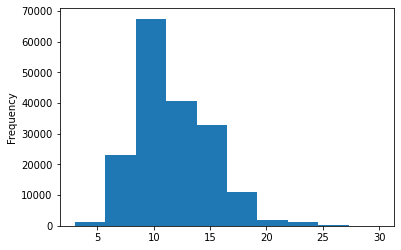

In [56]:
# Let's check the length of the different lines
train_df["total_lines"].plot.hist()

In [57]:
# Convert abstract text lines to list
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [58]:
# Convert target labels to numeric

# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder(sparse=False) # non spare matrix
train_labels_one_hot = one_hot.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [59]:
val_labels_one_hot = one_hot.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot.transform(test_df["target"].to_numpy().reshape(-1, 1))


In [60]:
# Label Encode Labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

## About the sentences

In [61]:
# How long is each sentence on average
import numpy as np
sent_length = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_length)
avg_sent_len


26.338269273494777

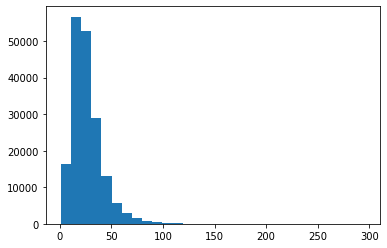

In [62]:
# What's the distribution
import matplotlib.pyplot as plt
plt.hist(sent_length, bins = 30);

In [63]:
# How long of a sentence length covers 95% of the training sentences
OUTPUT_SEQ_LENGHT = int(np.percentile(sent_length, 95))
OUTPUT_SEQ_LENGHT

55

## Get helper functions

In [64]:
from helper_functions import calculate_results

## Model Experiments:
1. `Model 0`: Baseline
2. `Model 1`: Conv1D With Token Embeddings
3. `Model 2`: Tensorflow Hub Feature Extractor
4. `Model 3`: Model 2 + Character Embeddings
5. `Model 4`: Model 3 + Positional Embeddings

### Model 0: Baseline

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create pipeline

model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(X = train_sentences,
            y = train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [66]:
# Evaluate baseline model on validation dataset
model_0.score(X = val_sentences,
            y = val_labels_encoded)

0.7218323844829869

In [67]:
# Calculate baseline results
baseline_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_0.predict(val_sentences))
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Text Vectorizer Layer

In [68]:
# How many words are in the vocab -> Table2 https://arxiv.org/abs/1710.06071

MAX_TOKENS = 68_000

In [69]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(
                                    max_tokens = MAX_TOKENS,
                                    output_sequence_length = OUTPUT_SEQ_LENGHT
                                    )

In [70]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [71]:
# Words in training vocab
rct_20k_text_vocab = text_vectorizer.get_vocabulary()

In [72]:
# Token Embeddings Layer
from tensorflow.keras import layers
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab),
                                output_dim = 128,
                                mask_zero = True,
                                name = "token_embedding")

### Creating Datasets Using Tensorflow Data API for Faster Performance and Data Loading

In [73]:
import tensorflow as tf
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [74]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [75]:
# Prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### Model 1: Conv1D with Token Embeddings

In [76]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [77]:
# create 1d conv model
inputs = layers.Input(shape = (1, ), dtype = tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size = 5, padding = "same",
                 activation = "relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5, activation = "softmax")(x)
model_1 = tf.keras.Model(inputs, outputs, name = "conv1d_model")


In [78]:
# Compile the model
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])
model_1.summary()               

Model: "conv1d_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_2 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_2   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 5)                

In [79]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                             steps_per_epoch = int(0.1*len(train_dataset)),
                             epochs = 5,
                             validation_data = val_dataset,
                             validation_steps = int(0.1*len(val_dataset)))

Epoch 1/5
562/562 [==============================] - 44s 78ms/step - loss: 0.9173 - accuracy: 0.6353 - val_loss: 0.6840 - val_accuracy: 0.7387
Epoch 2/5
562/562 [==============================] - 52s 93ms/step - loss: 0.6570 - accuracy: 0.7561 - val_loss: 0.6253 - val_accuracy: 0.7729
Epoch 3/5
562/562 [==============================] - 47s 83ms/step - loss: 0.6158 - accuracy: 0.7742 - val_loss: 0.5942 - val_accuracy: 0.7879
Epoch 4/5
562/562 [==============================] - 41s 73ms/step - loss: 0.5876 - accuracy: 0.7904 - val_loss: 0.5778 - val_accuracy: 0.7886
Epoch 5/5
562/562 [==============================] - 41s 74ms/step - loss: 0.5881 - accuracy: 0.7919 - val_loss: 0.5583 - val_accuracy: 0.8019


In [80]:
# Evaluate model on validation
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.5588 - accuracy: 0.8017


[0.5588036179542542, 0.8017013072967529]

In [85]:
# Calcualte results
model_1_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = tf.argmax(model_1.predict(val_dataset), axis = 1))
model_1_results

945/945 [==============================] - 4s 4ms/step


{'accuracy': 80.17013107374554,
 'precision': 0.8007890971108349,
 'recall': 0.8017013107374553,
 'f1': 0.7985551864156616}

In [86]:
# Convert the prediction probabilities to class to compare with actual labels
model_1_preds = tf.argmax(model_1.predict(val_dataset), axis = 1)
model_1_preds

945/945 [==============================] - 4s 4ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

### Model 2: Transfer Learning Tensorflow Hub Universal Sentence Encoder

In [88]:
# Download pretrained USE model
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                    trainable = False, name = "USE")


In [92]:
# Build the model
inputs = layers.Input(shape = [], dtype = tf.string)
embeddings = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation = "relu")(embeddings)
outputs = layers.Dense(5, activation = "softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name = "USE_Model")

# Compile the model
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Fit the model
history_model_2 = model_2.fit(train_dataset,
                             steps_per_epoch = int(0.1*len(train_dataset)),
                             epochs = 5,
                             validation_data = val_dataset,
                             validation_steps = int(0.1*len(val_dataset)))

Epoch 1/5
562/562 [==============================] - 7s 11ms/step - loss: 0.9214 - accuracy: 0.6459 - val_loss: 0.7971 - val_accuracy: 0.6895
Epoch 2/5
562/562 [==============================] - 6s 10ms/step - loss: 0.7700 - accuracy: 0.7006 - val_loss: 0.7542 - val_accuracy: 0.7048
Epoch 3/5
562/562 [==============================] - 6s 10ms/step - loss: 0.7528 - accuracy: 0.7111 - val_loss: 0.7378 - val_accuracy: 0.7128
Epoch 4/5
562/562 [==============================] - 6s 10ms/step - loss: 0.7181 - accuracy: 0.7245 - val_loss: 0.7097 - val_accuracy: 0.7307
Epoch 5/5
562/562 [==============================] - 6s 10ms/step - loss: 0.7261 - accuracy: 0.7225 - val_loss: 0.6890 - val_accuracy: 0.7380


In [94]:
# Evaluate the model
model_2_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred=tf.argmax(model_2.predict(val_dataset), axis =1))
model_2_results

945/945 [==============================] - 9s 10ms/step


{'accuracy': 73.42777704223488,
 'precision': 0.7305273591115358,
 'recall': 0.7342777704223488,
 'f1': 0.7285696522492813}

### Model 3: Character Level + Model 1